In [1]:
%pip install sagemaker --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 844.7/844.7 kB 37.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached attrs-23.1.0-py3-none-any.whl (61 kB)
  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
  Created wheel for sagemaker: filename=sagemaker-2.168.0-py2.py3-none-any.whl size=1151019 sha256=0ebe7d775f1cb563aa9146b58098816ef7058371095d4f0e152a12ce72e148c5
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c6/06/4f/71f8d1bfa307ba75786b2900cd9538f7282dc4b45a576bad5f
Successfully built sagemaker
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
  Attempting uninstall: attrs
    Found existing installation: attrs 22.2.0
    Uninstalling attrs-22.2.0:
      Successfully uninstalled attrs-22.2

In [1]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::159762733383:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole
sagemaker bucket: sagemaker-ap-southeast-1-159762733383
sagemaker session region: ap-southeast-1


# Deploy endpoint

In [5]:
# from sagemaker.huggingface.model import HuggingFaceModel
# from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig
# from sagemaker.s3 import s3_path_join

# # Hub Model configuration. <https://huggingface.co/models>
# hub = {
#     'HF_MODEL_ID':'stabilityai/stable-diffusion-2-inpainting'
# }

# # create Hugging Face Model Class
# huggingface_model = HuggingFaceModel(
#    env=hub,                      # configuration for loading model from Hub
#    role=role,                    # iam role with permissions to create an Endpoint
#    transformers_version="4.12",  # transformers version used
#    pytorch_version="1.9",        # pytorch version used
#    py_version='py38',            # python version used
# )

# # create async endpoint configuration
# async_config = AsyncInferenceConfig(
#     output_path=s3_path_join("s3://",sagemaker_session_bucket,"async_inference/output") , # Where our results will be stored
#     # notification_config={
#             #   "SuccessTopic": "arn:aws:sns:us-east-2:123456789012:MyTopic",
#             #   "ErrorTopic": "arn:aws:sns:us-east-2:123456789012:MyTopic",
#     # }, #  Notification configuration
# )

# # deploy the endpoint endpoint
# async_predictor = huggingface_model.deploy(
#     initial_instance_count=1,
#     instance_type="ml.g4dn.xlarge",
#     async_inference_config=async_config
# )

In [3]:
model_id, model_version = "model-inpainting-stabilityai-stable-diffusion-2-inpainting-fp16", "*"

from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base
from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig
from sagemaker.s3 import s3_path_join


endpoint_name = name_from_base(f"jumpstart-example-{model_id}")

# Instances with more GPU memory supports generation of larger images.
# So, please select instance types such as ml.g5.2xlarge if you want to generate a very large image.
inference_instance_type = "ml.g4dn.xlarge"

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the model uri. This includes the pre-trained model and parameters as well as the inference scripts.
# This includes all dependencies and scripts for model loading, inference handling etc..
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    model_data=model_uri,
    role=role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

# create async endpoint configuration
async_config = AsyncInferenceConfig(
    output_path=s3_path_join("s3://",sagemaker_session_bucket,"async_inference/output") , # Where our results will be stored
    # notification_config={
            #   "SuccessTopic": "arn:aws:sns:us-east-2:123456789012:MyTopic",
            #   "ErrorTopic": "arn:aws:sns:us-east-2:123456789012:MyTopic",
    # }, #  Notification configuration
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
async_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
    async_inference_config=async_config
)

---------!

# Add autoscaling policy

In [2]:
# endpoint_name = async_predictor.endpoint_name
endpoint_name = "jumpstart-example-model-inpainting-stab-2023-06-29-14-22-30-924"

In [21]:
# application-autoscaling client
asg_client = boto3.client("application-autoscaling")
cw_client = boto3.client("cloudwatch")

# This is the format in which application autoscaling references the endpoint
resource_id = f"endpoint/{endpoint_name}/variant/AllTraffic"

# Configure Autoscaling on asynchronous endpoint down to zero instances
response = asg_client.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=0,
    MaxCapacity=3,
)

# response = asg_client.put_scaling_policy(
#     PolicyName=f'Request-ScalingPolicy-{async_predictor.endpoint_name}',
#     ServiceNamespace="sagemaker",
#     ResourceId=resource_id,
#     ScalableDimension="sagemaker:variant:DesiredInstanceCount",
#     PolicyType="TargetTrackingScaling",
#     TargetTrackingScalingPolicyConfiguration={
#         "TargetValue": 3.0,
#         "CustomizedMetricSpecification": {
#             "MetricName": "ApproximateBacklogSizePerInstance",
#             "Namespace": "AWS/SageMaker",
#             "Dimensions": [{"Name": "EndpointName", "Value": async_predictor.endpoint_name}],
#             "Statistic": "Average",
#         },
#         "ScaleInCooldown": 600, # duration until scale in begins (down to zero)
#         "ScaleOutCooldown": 300 # duration between scale out attempts
#     },
# )

scale_out_response = asg_client.put_scaling_policy(
    PolicyName="HasBacklogWithoutCapacity-ScalingOutPolicy",
    ServiceNamespace="sagemaker",  # The namespace of the service that provides the resource.
    ResourceId=resource_id,  # Endpoint name
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",  # SageMaker supports only Instance Count
    PolicyType="StepScaling",  # 'StepScaling' or 'TargetTrackingScaling'
    StepScalingPolicyConfiguration={
        "AdjustmentType": "ChangeInCapacity", # Specifies whether the ScalingAdjustment value in the StepAdjustment property is an absolute number or a percentage of the current capacity. 
        "MetricAggregationType": "Average", # The aggregation type for the CloudWatch metrics.
        "Cooldown": 300, # The amount of time, in seconds, to wait for a previous scaling activity to take effect. 
        "StepAdjustments": # A set of adjustments that enable you to scale based on the size of the alarm breach.
        [ 
            {
              "MetricIntervalLowerBound": 0,
              "ScalingAdjustment": 1
            }
          ]
    },    
)
print(scale_out_response)


scale_in_response = asg_client.put_scaling_policy(
    PolicyName="HasBacklogWithoutCapacity-ScalingInPolicy",
    ServiceNamespace="sagemaker",  # The namespace of the service that provides the resource.
    ResourceId=resource_id,  # Endpoint name
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",  # SageMaker supports only Instance Count
    PolicyType="StepScaling",  # 'StepScaling' or 'TargetTrackingScaling'
    StepScalingPolicyConfiguration={
        "AdjustmentType": "ChangeInCapacity", # Specifies whether the ScalingAdjustment value in the StepAdjustment property is an absolute number or a percentage of the current capacity. 
        "MetricAggregationType": "Average", # The aggregation type for the CloudWatch metrics.
        "Cooldown": 1200, # The amount of time, in seconds, to wait for a previous scaling activity to take effect. 
        "StepAdjustments": # A set of adjustments that enable you to scale based on the size of the alarm breach.
        [ 
            {
              "MetricIntervalLowerBound": 0,
              "ScalingAdjustment": -1
            }
          ]
    },    
)
print(scale_in_response)



cw_out_response = cw_client.put_metric_alarm(
    AlarmName="Sagemaker-AddCapacity-Alarm",
    MetricName='HasBacklogWithoutCapacity',
    Namespace='AWS/SageMaker',
    Statistic='Minimum',
    EvaluationPeriods= 1,
    DatapointsToAlarm= 1,
    Threshold= 1,
    ComparisonOperator='GreaterThanOrEqualToThreshold',
    TreatMissingData='missing',
    Dimensions=[
        { 'Name':'EndpointName', 'Value': endpoint_name },
    ],
    Period= 60,
    AlarmActions=[scale_out_response['PolicyARN']]
)

cw_in_response = cw_client.put_metric_alarm(
    AlarmName="Sagemaker-ReduceCapacity-Alarm",
    MetricName='ApproximateBacklogSize',
    Namespace='AWS/SageMaker',
    Statistic='Maximum',
    EvaluationPeriods= 5,
    DatapointsToAlarm= 5,
    Threshold= 0,
    ComparisonOperator='LessThanOrEqualToThreshold',
    TreatMissingData='missing',
    Dimensions=[
        { 'Name':'EndpointName', 'Value': endpoint_name },
    ],
    Period= 300,
    AlarmActions=[scale_in_response['PolicyARN']]
)



{'PolicyARN': 'arn:aws:autoscaling:ap-southeast-1:159762733383:scalingPolicy:3dcd84a2-c9e2-4fa3-a3aa-f22b44bf0444:resource/sagemaker/endpoint/jumpstart-example-model-inpainting-stab-2023-06-29-14-22-30-924/variant/AllTraffic:policyName/HasBacklogWithoutCapacity-ScalingOutPolicy', 'Alarms': [], 'ResponseMetadata': {'RequestId': '3d660333-cd39-47a6-a315-a26ca26d4268', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '3d660333-cd39-47a6-a315-a26ca26d4268', 'content-type': 'application/x-amz-json-1.1', 'content-length': '291', 'date': 'Thu, 29 Jun 2023 19:05:21 GMT'}, 'RetryAttempts': 0}}
{'PolicyARN': 'arn:aws:autoscaling:ap-southeast-1:159762733383:scalingPolicy:3dcd84a2-c9e2-4fa3-a3aa-f22b44bf0444:resource/sagemaker/endpoint/jumpstart-example-model-inpainting-stab-2023-06-29-14-22-30-924/variant/AllTraffic:policyName/HasBacklogWithoutCapacity-ScalingInPolicy', 'Alarms': [], 'ResponseMetadata': {'RequestId': '779be818-847e-4bf2-ac11-0a9f0aadfca1', 'HTTPStatusCode': 200, 'HTTPHe

# Invoke endpoint

In [13]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 25.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 28.0 MB/s eta 0:00:00:00:0100:01


In [14]:
import cv2 
import numpy as np
from PIL import Image
import base64
from io import BytesIO
import json
from skimage.metrics import structural_similarity

s3 = boto3.client("s3")

def get_mask(image1_pil, image2_pil):

    # Convert to cv2 format
    image1_np = np.array(image1_pil)
    image2_np = np.array(image2_pil)
    image1_bgr = cv2.cvtColor(image1_np, cv2.COLOR_RGB2BGR)
    image2_bgr = cv2.cvtColor(image2_np, cv2.COLOR_RGB2BGR)

    # # METHOD 2: Use structural similarity and contour regions
    before_gray = cv2.cvtColor(image1_bgr, cv2.COLOR_BGR2GRAY)
    after_gray = cv2.cvtColor(image2_bgr, cv2.COLOR_BGR2GRAY)
    (score, diff) = structural_similarity(before_gray, after_gray, full=True) # Compute SSIM between the two images
    diff = (diff * 255).astype("uint8")
    diff_box = cv2.merge([diff, diff, diff])
    # Threshold the difference image, followed by finding contours to obtain the regions of the two input images that differ
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    mask = np.zeros(image1_bgr.shape, dtype='uint8')
    for c in contours:
        area = cv2.contourArea(c)
        if area > 10: # minimum contour area
            cv2.drawContours(mask, [c], 0, (255,255,255), -1)

    # convert mask back to PIL
    mask_pil = Image.fromarray(mask)
    return mask_pil

def get_image_s3(bucket, key):
    file_byte_string = s3.get_object(Bucket=bucket, Key=key)["Body"].read()
    image = Image.open(BytesIO(file_byte_string))

    return image

def pil2bytes(pil_image):
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")
    img_bytes = base64.b64encode(buffered.getvalue()).decode()
    
    return img_bytes

In [15]:
s3_bucket = f"woaiai-test"
key_prefix = "removal"
original_key = "original_2.jpg"
masked_key = "masked_2.jpg"

original = get_image_s3(s3_bucket, f"{key_prefix}/{original_key}")
masked = get_image_s3(s3_bucket, f"{key_prefix}/{masked_key}")
mask = get_mask(original, masked)

payload = {
    "prompt": "",
    "image": pil2bytes(original),
    "mask_image": pil2bytes(mask),
    "num_inference_steps": 50,
    "guidance_scale": 7.5,
    "seed": 0
}

request_payload_key = f"{key_prefix}/payload.json"
input_s3_location = s3.put_object(
    Body=json.dumps(payload).encode("utf-8"),
    Bucket=s3_bucket,
    Key=request_payload_key,
    ContentType='application/json'
)

In [16]:
import urllib
from botocore.exceptions import ClientError
import time
def get_output(output_location, sm_session):
    output_url = urllib.parse.urlparse(output_location)
    bucket = output_url.netloc
    key = output_url.path[1:]
    while True:
        try:
            return sm_session.read_s3_file(bucket=output_url.netloc, key_prefix=output_url.path[1:])
        except ClientError as e:
            if e.response["Error"]["Code"] == "NoSuchKey":
                print("waiting for output...")
                time.sleep(10)
                continue
            raise

In [17]:
endpoint_name = "jumpstart-example-model-inpainting-stab-2023-06-29-14-22-30-924"
boto_session = boto3.session.Session()
sm_runtime = boto_session.client("sagemaker-runtime")

resp = sm_runtime.invoke_endpoint_async(
        EndpointName=endpoint_name, InputLocation=f"s3://{s3_bucket}/{request_payload_key}", ContentType='application/json;jpeg'
    )

output_location = resp["OutputLocation"]
print(f"Response object: {resp}")
print(f"Response output path: {output_location}")


Response object: {'ResponseMetadata': {'RequestId': '35250050-c158-4385-8ce4-4c50fec16f7a', 'HTTPStatusCode': 202, 'HTTPHeaders': {'x-amzn-requestid': '35250050-c158-4385-8ce4-4c50fec16f7a', 'x-amzn-sagemaker-outputlocation': 's3://sagemaker-ap-southeast-1-159762733383/async_inference/output/4399f9f7-b5f9-4352-9845-06e620358973.out', 'x-amzn-sagemaker-failurelocation': 's3://sagemaker-ap-southeast-1-159762733383/async-endpoint-failures/jumpstart-example-model-inpainting-stab-2023-06-1688048552-b3ca/4399f9f7-b5f9-4352-9845-06e620358973-error.out', 'date': 'Thu, 29 Jun 2023 18:44:50 GMT', 'content-type': 'application/json', 'content-length': '54'}, 'RetryAttempts': 0}, 'OutputLocation': 's3://sagemaker-ap-southeast-1-159762733383/async_inference/output/4399f9f7-b5f9-4352-9845-06e620358973.out', 'FailureLocation': 's3://sagemaker-ap-southeast-1-159762733383/async-endpoint-failures/jumpstart-example-model-inpainting-stab-2023-06-1688048552-b3ca/4399f9f7-b5f9-4352-9845-06e620358973-error.ou

In [18]:
output = get_output(output_location, sess)
generated_images = json.loads(output)["generated_images"]

waiting for output...


In [11]:
import matplotlib.pyplot as plt
import numpy as np
def display_img_and_prompt(img, prmpt):
    """Display the generated image."""
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

Matplotlib is building the font cache; this may take a moment.


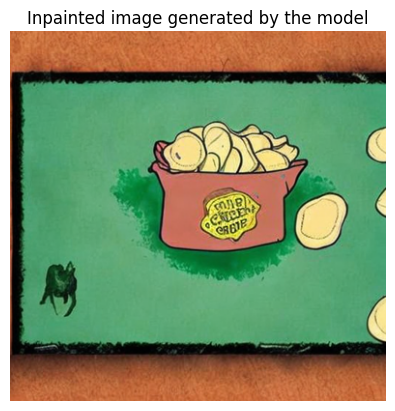

In [12]:
for image in generated_images:
    display_img_and_prompt(image, "Inpainted image generated by the model")

In [20]:
np.array(image).shape

(383, 389, 3)

In [58]:
import io
def save_image_s3(image_list):
    np_image = (np.array(image_list)).astype(np.uint8)
    img = Image.fromarray(np_image)

    in_mem_file = BytesIO()
    img.save(in_mem_file, format='png')
    in_mem_file.seek(0)
    response = s3.upload_fileobj(in_mem_file, s3_bucket, f"{key_prefix}/result.jpg")

In [59]:
save_image_s3(image)

## invoke via predictor class (archive)

In [48]:
region = boto3.Session().region_name
s3_bucket = f"woaiai-test"
key_prefix = "removal"
input_img_file_name = "original_2.jpg"
input_img_mask_file_name = "pre_mask.png"

s3.download_file(s3_bucket, f"{key_prefix}/{input_img_file_name}", input_img_file_name)
s3.download_file(s3_bucket, f"{key_prefix}/{input_img_mask_file_name}", input_img_mask_file_name)


import base64
from PIL import Image
from io import BytesIO
# content_type = 'application/json;jpeg', endpoint expects payload to be a json with the original image and the mask image as bytes encoded with base64.b64 encoding.
# To send raw image to the endpoint, you can set content_type = 'application/json' and encoded_image as np.array(PIL.Image.open(input_img_file_name.jpg)).tolist()
content_type = "application/json;jpeg"


with open(input_img_file_name, "rb") as f:
    input_img_image_bytes = f.read()
with open(input_img_mask_file_name, "rb") as f:
    input_img_mask_image_bytes = f.read()

encoded_input_image = base64.b64encode(bytearray(input_img_image_bytes)).decode()
encoded_mask = base64.b64encode(bytearray(input_img_mask_image_bytes)).decode()

payload = {
    "prompt": "",
    "image": encoded_input_image,
    "mask_image": encoded_mask,
    "num_inference_steps": 50,
    "guidance_scale": 7.5,
    "seed": 0
}


In [49]:
from sagemaker.async_inference.waiter_config import WaiterConfig
import json

resp = async_predictor.predict_async(data=json.dumps(payload).encode("utf-8"), initial_args={'ContentType': 'application/json;jpeg'})

print(f"Response object: {resp}")
print(f"Response output path: {resp.output_path}")
print("Start Polling to get response:")

config = WaiterConfig(
  max_attempts=5, #  number of attempts
  delay=10 #  time in seconds to wait between attempts
  )

image = json.loads(resp.get_result(config))["generated_images"]

Response object: <sagemaker.async_inference.async_inference_response.AsyncInferenceResponse object at 0x7f30078d2f50>
Response output path: s3://sagemaker-ap-southeast-1-159762733383/async_inference/output/246260bd-f6dc-45c7-a8ff-202eb020c06d.out
Start Polling to get response:


In [50]:
import matplotlib.pyplot as plt
import numpy as np
def display_img_and_prompt(img, prmpt):
    """Display the generated image."""
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

Matplotlib is building the font cache; this may take a moment.


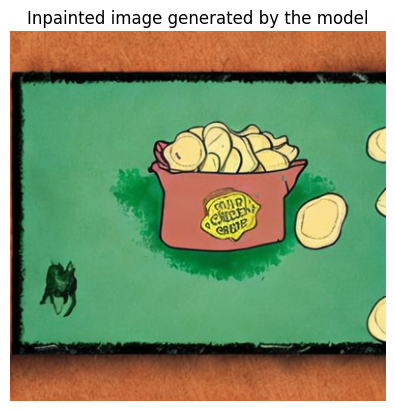

In [51]:
# for img in image:
# generated_image_decoded = BytesIO(base64.b64decode(img.encode()))
# generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
display_img_and_prompt(image[0], "Inpainted image generated by the model")